<a href="https://colab.research.google.com/github/heroza/DeepSMOTE/blob/main/GenerateSamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11.3
['/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_img/0_trn_img.txt']
['/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_lab/0_trn_lab.txt']
0
/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_img/0_trn_img.txt
/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_lab/0_trn_lab.txt
train imgs before reshape  (9000, 784)
train labels  (9000,)


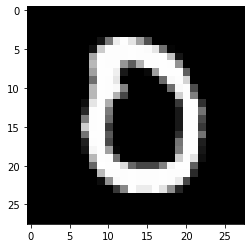

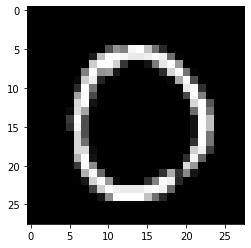

decy  (9000,)
Counter({0.0: 4000, 1.0: 2000, 2.0: 1000, 3.0: 750, 4.0: 500, 5.0: 350, 6.0: 200, 7.0: 100, 8.0: 60, 9.0: 40})
train imgs after reshape  (9000, 1, 28, 28)
(2000, 1, 28, 28)
1.0
torch.Size([2000, 300])
(2000, 300)
2000
(2000,)
(2000, 1, 28, 28)
(2000, 1, 28, 28)
(1000, 1, 28, 28)
2.0
torch.Size([1000, 300])
(3000, 300)
3000
(3000,)
(3000, 1, 28, 28)
(3000, 1, 28, 28)
(750, 1, 28, 28)
3.0
torch.Size([750, 300])
(3250, 300)
3250
(3250,)
(3250, 1, 28, 28)
(3250, 1, 28, 28)
(500, 1, 28, 28)
4.0
torch.Size([500, 300])
(3500, 300)
3500
(3500,)
(3500, 1, 28, 28)
(3500, 1, 28, 28)
(350, 1, 28, 28)
5.0
torch.Size([350, 300])
(3650, 300)
3650
(3650,)
(3650, 1, 28, 28)
(3650, 1, 28, 28)
(200, 1, 28, 28)
6.0
torch.Size([200, 300])
(3800, 300)
3800
(3800,)
(3800, 1, 28, 28)
(3800, 1, 28, 28)
(100, 1, 28, 28)
7.0
torch.Size([100, 300])
(3900, 300)
3900
(3900,)
(3900, 1, 28, 28)
(3900, 1, 28, 28)
(60, 1, 28, 28)
8.0
torch.Size([60, 300])
(3940, 300)
3940
(3940,)
(3940, 1, 28, 28)
(3940, 

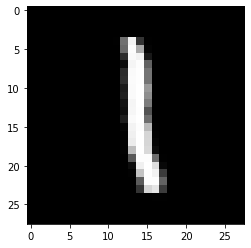

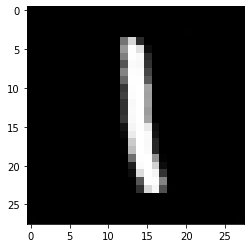


final time(min): 0.60


In [2]:
# -*- coding: utf-8 -*-
from matplotlib import pyplot as plt
import collections
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
print(torch.version.cuda) #10.1
import time
t0 = time.time()
##############################################################################
"""args for models"""

args = {}
args['dim_h'] = 64          # factor controlling size of hidden layers
args['n_channel'] = 1       # number of channels in the input data 

args['n_z'] = 300 #600     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 1 #50         # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['dataset'] = 'mnist' #'fmnist' # specify which dataset to use

##############################################################################

## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            
            #3d and 32 by 32
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True) )#,
            #nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False))
            #nn.Conv2d(self.dim_h * 8, 1, 4, 1, 0, bias=False))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        #print('aft conv ',x.size()) #torch.Size([100, 320, 2, 2]) with 
        #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
        #vs torch.Size([128, 320, 1, 1])
        #aft conv  torch.Size([100, 320, 1, 1]) with 
        #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            #nn.Sigmoid()
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################

def biased_get_class1(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM1(X, y,n_to_sample,cl):

    
    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#############################################################################
np.printoptions(precision=5,suppress=True)

dtrnimg = '/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_img/'
dtrnlab = '/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_lab/'

ids = os.listdir(dtrnimg)
idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
print(idtri_f)

ids = os.listdir(dtrnlab)
idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
print(idtrl_f)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/models/crs5/'

encf = []
decf = []
for p in range(len(ids)):
    enc = modpth + '/' + str(p) + '/bst_enc.pth'
    dec = modpth + '/' + str(p) + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)
    #print(enc)
    #print(dec)
    #print()

for m in range(len(ids)):
    print(m)
    trnimgfile = idtri_f[m]
    trnlabfile = idtrl_f[m]
    print(trnimgfile)
    print(trnlabfile)
    dec_x = np.loadtxt(trnimgfile) 
    dec_y = np.loadtxt(trnlabfile)

    print('train imgs before reshape ',dec_x.shape) #(44993, 3072) 45500, 3072)
    print('train labels ',dec_y.shape) #(44993,) (45500,)

    dec_x = dec_x.reshape(dec_x.shape[0],1,28,28)
    
    plt.imshow(dec_x[0,0], cmap='gray')
    plt.show()
    plt.imshow(dec_x[110,0], cmap='gray')
    plt.show()

    print('decy ',dec_y.shape)
    print(collections.Counter(dec_y))
    
    print('train imgs after reshape ',dec_x.shape) #(45000,3,32,32)

    classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    #imbal = [4500, 2000, 1000, 800, 600, 500, 400, 250, 150, 80]
    imbal = [4000, 2000, 1000, 750, 500, 350, 200, 100, 60, 40]

    resx = []
    resy = []

    for i in range(1,10):
        xclass, yclass = biased_get_class1(i)
        print(xclass.shape) #(500, 3, 32, 32)
        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
        print(xclass.shape) #torch.Size([500, 600])
            
        xclass = xclass.detach().cpu().numpy()
        n = imbal[0] - imbal[i]
        xsamp, ysamp = G_SM1(xclass,yclass,n,i)
        print(xsamp.shape) #(4500, 600)
        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
        print(ysamp.shape) #4500   
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        #xsamp = xsamp.view(xsamp.size()[0], xsamp.size()[1], 1, 1)
        #print(xsamp.size()) #torch.Size([10, 600, 1, 1])
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
        print(ximn.shape) #(4500, 3, 32, 32)
        #ximn = np.expand_dims(ximn,axis=1)
        print(ximn.shape) #(4500, 3, 32, 32)
        resx.append(ximn)
        resy.append(ysamp)
        #print('resx ',resx.shape)
        #print('resy ',resy.shape)
        #print()
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
    #print(resx1.shape) #(34720, 3, 32, 32)
    #resx1 = np.squeeze(resx1)
    print(resx1.shape) #(34720, 3, 32, 32)
    print(resy1.shape) #(34720,)

    resx1 = resx1.reshape(resx1.shape[0],-1)
    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = dec_x.reshape(dec_x.shape[0],-1)
    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,dec_y))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)

    dec_x_plt = combx.reshape(combx.shape[0],1,28,28)
    plt.imshow(dec_x_plt[0,0], cmap='gray')
    plt.show()
    plt.imshow(dec_x_plt[110,0], cmap='gray')
    plt.show()

    ifile = '/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_img_f/' + \
        str(m) + '_trn_img.txt'
    np.savetxt(ifile, combx)
    
    lfile = '/content/drive/MyDrive/PHD/DeepSMOTE/MNIST/trn_lab_f/' + \
        str(m) + '_trn_lab.txt'
    np.savetxt(lfile,comby) 
    print()

t1 = time.time()
print('final time(min): {:.2f}'.format((t1 - t0)/60))